In [1]:
## Importing packages

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

# For closed-form solution
from scipy.integrate import quad
from scipy.optimize import fsolve

In [3]:
## I need w_bar here
B = 0.5
c = 0.05
β = 0.9

## PDF of wages uniformly distributed on [0, B]
f = lambda w: 1/B if 0 <= w <= B else 0

def indifference(w):
    LHS = w-c
    integrand = lambda z: (z - w) * f(z)
    integral, error = quad(integrand, w, B)
    
    RHS = (β/(1-β))* integral
    return LHS-RHS
    
w_bar = fsolve(indifference, x0=0.5)[0]


In [4]:
## Config for plotting

In [5]:
fontsize= 14
ticksize = 14
figsize = (8, 6)
params_fig = {'font.family':'serif',
    "figure.figsize":figsize,
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params_fig)

In [6]:
## importing a file to see how the plots going to look like 

In [7]:
def load_all_results_test(max_eps=99, folder="."):
    results = {}

    for eps in range(max_eps, -1, -1):  # from 99 down to 0
        # build filenames
        test_file = f"{folder}/training_results_eps_{eps}_test.csv"

        # read CSV
        df_test = pd.read_csv(test_file)

        # store keyed by eps
        results[eps] = df_test

    return results

In [8]:
def load_all_results_train(max_eps=99, folder="."):
    results = {}

    for eps in range(max_eps, -1, -1):  # from 99 down to 0
        # build filenames
        test_file = f"{folder}/training_results_eps_{eps}_train.csv"

        # read CSV
        df_test = pd.read_csv(test_file)

        # store keyed by eps
        results[eps] = df_test

    return results

In [9]:
### Lets focus on some specific plot

In [10]:
results_test = load_all_results_test(max_eps=99)
results_train = load_all_results_train(max_eps=99)

df_66_test = results_test[66]
df_66_train = results_train[66]


In [11]:
v_theory = df_66_test["v_theory"]
v_hat = df_66_test["v_hat"]
w_test = df_66_test["w_test"]
w_train = df_66_train["w_train"]
rel_error = (v_theory-v_hat)/v_theory
abs_rel_error = np.abs(rel_error)

In [12]:
mask_bound_left =  (w_train <= w_bar)
lower_bound_left =  w_train[mask_bound_left].max()

mask_bound_right = (w_train > w_bar)
lower_bound_right =  w_train[mask_bound_right].min()

lower = 0.0
upper = w_test.max()

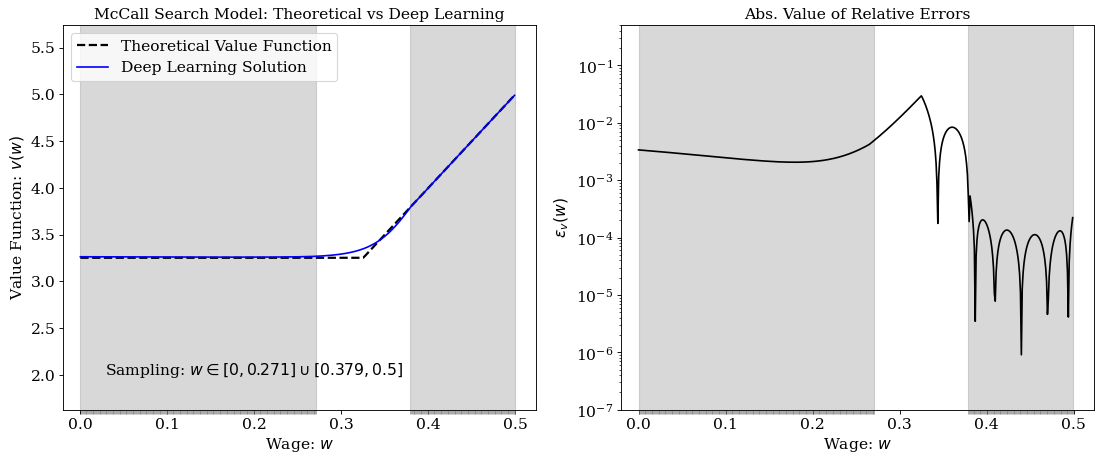

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ---- Left panel ----
axes[0].plot(w_test, v_theory, label="Theoretical Value Function", linestyle="--" ,color="black", linewidth=2)
axes[0].plot(w_test, v_hat, label="Deep Learning Solution", color="blue", )
y_min = min(v_theory.min(), v_hat.min())
y_max = max(v_theory.max(), v_hat.max())
axes[0].set_ylim(y_min * 0.5, y_max * 1.15)
axes[0].set_xticks(axes[0].get_xticks())  

# add training points as minor ticks
axes[0].set_xticks(w_train.squeeze().tolist(), minor=True)
axes[0].tick_params(axis="x", which="minor", length=4, color="gray")
axes[0].set_xlim(-0.02, 1.05*w_test.max())
axes[0].axvspan(lower, lower_bound_left, color="gray", alpha=0.3)
axes[0].axvspan(lower_bound_right, upper,color="gray", alpha=0.3)

axes[0].set_xlabel(r"Wage: $w$")
axes[0].set_ylabel(r"Value Function: $v(w)$")
axes[0].set_title("McCall Search Model: Theoretical vs Deep Learning")
axes[0].text(
    0.2, 2,
    f"Sampling: $w \\in [{lower:.3g}, {lower_bound_left:.3g}] \\cup [{lower_bound_right:.3g}, {B:.3g}]$",
    ha='center',
    fontsize=14
)
axes[0].legend(loc = "upper left")

# ---- Right panel ----
axes[1].plot(w_test, abs_rel_error, color="k")
axes[1].set_xticks(w_train.squeeze().tolist(), minor=True)
axes[1].tick_params(axis="x", which="minor", length=4, color="gray")
axes[1].set_xlim(-0.02, 1.05*w_test.max())
axes[1].axvspan(lower, lower_bound_left, color="gray", alpha=0.3)
axes[1].axvspan(lower_bound_right, upper,color="gray", alpha=0.3)
axes[1].set_ylim(1e-7,5e-1)
axes[1].set_xlabel(r"Wage: $w$")
axes[1].set_ylabel(r"$\varepsilon_v(w)$")
axes[1].set_yscale("log")
axes[1].set_title(r"Abs. Value of Relative Errors")

plt.tight_layout()
plt.show()

# Makin the animation 


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio  # use v2 API to avoid warning

In [15]:
filenames = []
#for i in range(epoch_outputs.shape[0]):
for i in range(100):
    df_test = results_test[i]
    df_train = results_train[i]
    v_theory = df_test["v_theory"]
    v_hat = df_test["v_hat"]
    w_test = df_test["w_test"]
    w_train = df_train["w_train"]
    rel_error = (v_theory-v_hat)/v_theory
    abs_rel_error = np.abs(rel_error)
    mask_bound_left =  (w_train <= w_bar)
    lower_bound_left =  w_train[mask_bound_left].max()

    mask_bound_right = (w_train > w_bar)
    lower_bound_right =  w_train[mask_bound_right].min()

    lower = 0
    upper = w_test.max()
    for t in range(5):
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # ---- Left panel ----
        axes[0].plot(w_test, v_theory, label="Theoretical Value Function", linestyle="--" ,color="black", linewidth=2)
        axes[0].plot(w_test, v_hat, label="Deep Learning Solution", color="blue", )
        y_min = min(v_theory.min(), v_hat.min())
        y_max = max(v_theory.max(), v_hat.max())
        axes[0].set_ylim(y_min * 0.5, y_max * 1.15)
        axes[0].set_xticks(axes[0].get_xticks())  

        # add training points as minor ticks
        axes[0].set_xticks(w_train.squeeze().tolist(), minor=True)
        axes[0].tick_params(axis="x", which="minor", length=4, color="gray")
        axes[0].set_xlim(-0.02, 1.05*w_test.max())
        axes[0].axvspan(lower, lower_bound_left, color="gray", alpha=0.3)
        axes[0].axvspan(lower_bound_right, upper,color="gray", alpha=0.3)

        axes[0].set_xlabel(r"Wage: $w$")
        axes[0].set_ylabel(r"Value Function: $v(w)$")
        axes[0].set_title("McCall Search Model: Theoretical vs Deep Learning")
        axes[0].text(0.2, 2,
    f"Sampling: $w \\in [{lower:.3g}, {lower_bound_left:.3g}] \\cup [{lower_bound_right:.3g}, {B:.3g}]$",
    ha='center',
    fontsize=14
)

        axes[0].legend(loc = "upper left")

        # ---- Right panel ----
        axes[1].plot(w_test, abs_rel_error, color="k")
        axes[1].set_xticks(w_train.squeeze().tolist(), minor=True)
        axes[1].tick_params(axis="x", which="minor", length=4, color="gray")
        axes[1].set_xlim(-0.02, 1.05*w_test.max())
        axes[1].axvspan(lower, lower_bound_left, color="gray", alpha=0.3)
        axes[1].axvspan(lower_bound_right, upper,color="gray", alpha=0.3)
        axes[1].set_ylim(1e-7,5e-1)
        axes[1].set_xlabel(r"Wage: $w$")
        axes[1].set_ylabel(r"$\varepsilon_v(w)$")
        axes[1].set_yscale("log")
        axes[1].set_title(r"Abs. Value of Relative Errors")
        filename = f'{i}{t}.png'
        
        filenames.append(filename)

    # save frame
        plt.savefig(filename)
        plt.close()# build gif

with imageio.get_writer('McCall.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)
        